In [1]:
import os
import csv
import platform
import pandas as pd
import networkx as nx
from graph_partitioning import GraphPartitioning, utils

run_metrics = True

#cols = ["WASTE", "CUT RATIO", "EDGES CUT", "TOTAL COMM VOLUME", "MODULARITY", "LONELINESS", "NETWORK PERMANENCE", "NORM. MUTUAL INFO", "EDGE CUT WEIGHT", "FSCORE", "FSCORE RELABEL IMPROVEMENT"]
cols = ["WASTE", "CUT RATIO", "EDGES CUT", "TOTAL COMM VOLUME", "Qds", "CONDUCTANCE", "MAXPERM", "NMI", "FSCORE", "FSCORE RELABEL IMPROVEMENT"]

pwd = %pwd

config = {
    "DATA_FILENAME": os.path.join(pwd, "data", "predition_model_tests", "network", "rand_edge_weights", "network_1.txt"),
    #"DATA_FILENAME": os.path.join(pwd, "data", "predition_model_tests", "network", "network_1.txt"),
    "OUTPUT_DIRECTORY": os.path.join(pwd, "output"),

    # Set which algorithm is run for the PREDICTION MODEL.
    # Either: 'FENNEL' or 'SCOTCH'
    "PREDICTION_MODEL_ALGORITHM": "PATOH",

    # Alternativly, read input file for prediction model.
    # Set to empty to generate prediction model using algorithm value above.
    "PREDICTION_MODEL": "",

    "PARTITIONER_ALGORITHM": "PATOH",

    # File containing simulated arrivals. This is used in simulating nodes
    # arriving at the shelter. Nodes represented by line number; value of
    # 1 represents a node as arrived; value of 0 represents the node as not
    # arrived or needing a shelter.
    "SIMULATED_ARRIVAL_FILE": os.path.join(pwd,
                                           "data",
                                           "predition_model_tests",
                                           "dataset_1_shift_rotate",
                                           "simulated_arrival_list",
                                           "percentage_of_prediction_correct_90",
                                           "arrival_90_1.txt"
                                          ),
    
    # File containing the prediction of a node arriving. This is different to the
    # simulated arrivals, the values in this file are known before the disaster.
    "PREDICTION_LIST_FILE": os.path.join(pwd,
                                         "data",
                                         "predition_model_tests",
                                         "dataset_1_shift_rotate",
                                         "prediction_list",
                                         "prediction_1.txt"
                                        ),

    # File containing the geographic location of each node, in "x,y" format.
    "POPULATION_LOCATION_FILE": os.path.join(pwd,
                                             "data",
                                             "predition_model_tests",
                                             "coordinates",
                                             "coordinates_1.txt"
                                            ),

    # Number of shelters
    "num_partitions": 4,

    # The number of iterations when making prediction model
    "num_iterations": 1,

    # Percentage of prediction model to use before discarding
    # When set to 0, prediction model is discarded, useful for one-shot
    "prediction_model_cut_off": 0.0,

    # Alpha value used in one-shot (when restream_batches set to 1)
    "one_shot_alpha": 0.5,

    # Number of arrivals to batch before recalculating alpha and restreaming.
    # When set to 1, one-shot is used with alpha value from above
    "restream_batches": 40,

    # When the batch size is reached: if set to True, each node is assigned
    # individually as first in first out. If set to False, the entire batch
    # is processed and empty before working on the next batch.
    "sliding_window": False,

    # Create virtual nodes based on prediction model
    "use_virtual_nodes": False,

    # Virtual nodes: edge weight
    "virtual_edge_weight": 1.0,

    # Loneliness score parameter. Used when scoring a partition by how many
    # lonely nodes exist.
    "loneliness_score_param": 1.2,

    ####
    # GRAPH MODIFICATION FUNCTIONS

    # Also enables the edge calculation function.
    "graph_modification_functions": True,

    # If set, the node weight is set to 100 if the node arrives at the shelter,
    # otherwise the node is removed from the graph.
    "alter_arrived_node_weight_to_100": False,

    # Uses generalized additive models from R to generate prediction of nodes not
    # arrived. This sets the node weight on unarrived nodes the the prediction
    # given by a GAM.
    # Needs POPULATION_LOCATION_FILE to be set.
    "alter_node_weight_to_gam_prediction": False,

    # Enables edge expansion when graph_modification_functions is set to true
    "edge_expansion_enabled": True,

    # The value of 'k' used in the GAM will be the number of nodes arrived until
    # it reaches this max value.
    "gam_k_value": 100,

    # Alter the edge weight for nodes that haven't arrived. This is a way to
    # de-emphasise the prediction model for the unknown nodes.
    "prediction_model_emphasis": 1.0,
    
    # This applies the prediction_list_file node weights onto the nodes in the graph
    # when the prediction model is being computed and then removes the weights
    # for the cutoff and batch arrival modes
    "apply_prediction_model_weights": True,

    "SCOTCH_LIB_PATH": os.path.join(pwd, "libs/scotch/macOS/libscotch.dylib")
    if 'Darwin' in platform.system()
    else "/usr/local/lib/libscotch.so",
    
    # Path to the PaToH shared library
    "PATOH_LIB_PATH": os.path.join(pwd, "libs/patoh/lib/macOS/libpatoh.dylib")
    if 'Darwin' in platform.system()
    else os.path.join(pwd, "libs/patoh/lib/linux/libpatoh.so"),
    
    "PATOH_ITERATIONS": 5,
        
    # Expansion modes: 'avg_node_weight', 'total_node_weight', 'smallest_node_weight'
    # 'largest_node_weight'
    # add '_squared' or '_sqrt' at the end of any of the above for ^2 or sqrt(weight)
    # i.e. 'avg_node_weight_squared
    "PATOH_HYPEREDGE_EXPANSION_MODE": 'avg_node_weight',

    # Whether nodes should be reordered using a centrality metric for optimal node assignments in batch mode
    # This is specific to FENNEL and at the moment Leverage Centrality is used to compute new noder orders
    "FENNEL_NODE_REORDERING_ENABLED": False,
    
    # Whether the Friend of a Friend scoring system is active during FENNEL partitioning.
    # FOAF employs information about a node's friends to determine the best partition when
    # this node arrives at a shelter and no shelter has friends already arrived
    "FENNEL_FRIEND_OF_A_FRIEND_ENABLED": True,    
    
    # Alters how much information to print. Keep it at 1 for this notebook.
    # 0 - will print nothing, useful for batch operations.
    # 1 - prints basic information on assignments and operations.
    # 2 - prints more information as it batches arrivals.
    "verbose": 1
}

gp = GraphPartitioning(config)

# Optional: shuffle the order of nodes arriving
# Arrival order should not be shuffled if using GAM to alter node weights
#random.shuffle(gp.arrival_order)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
gp.load_network()

Graph loaded...
Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 2938
Average degree:   5.8760
Graph is undirected


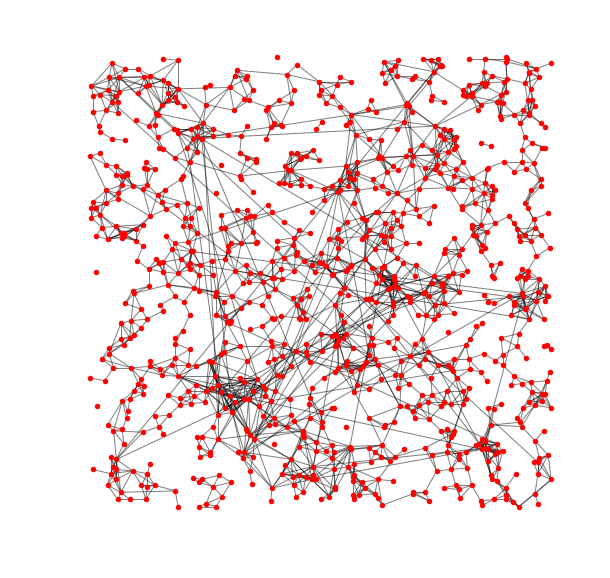

In [3]:
pos = {}
with open(gp.POPULATION_LOCATION_FILE, 'r') as csvfile: 
    reader = csv.reader(csvfile, delimiter=',')
    for node, row in enumerate(reader):
        pos[node] = np.array(row).astype(np.float)

plt.figure(figsize=(10, 10))
plt.axis('off')

nx.draw_networkx_nodes(gp.G, pos, node_size=20, cmap=plt.cm.jet, with_labels=False)
nx.draw_networkx_edges(gp.G, pos, alpha=0.5)
plt.show(gp.G)

In [4]:
gp.init_partitioner()

PaToH partitioner loaded for generating PREDICTION MODEL.
PaToH partitioner loaded for making shelter assignments.


# Prediction Model

In [5]:
m = gp.prediction_model()

Ran PaToH for 5 iterations with min_tcv = 242 and max_tcv = 321  - picked min_TCV assignements.
PREDICTION MODEL
----------------


Assignments:
[ 2  2  1  2  3  1  2  3  0  0  2  1  3  0  3  2  3  1  0  3  0  3  2  1  1  1  1  2  3  1  1  2  2  2  3  3  2  2  3  1  0  2  1  3  3  3  2  1  1  2  3  2  2  3  2  1  3  0  3  2  3  0  2  1  3  2  3  2  2  2  0  2  2  2  1  1  1  2  3  3  2  0  2  3  2  3  1  0  2  2  2  2  3  3  2  2  2  1  3  2  2  2  3  2  3  2  3  1  2  2  2  1  1  0  2  2  2  1  2  2  2  3  1  2  2  2  1  2  3  3  3  1  2  2  0  2  1  2  2  0  0  2  2  1  2  2  2  2  3  2  2  0  2  1  3  2  1  3  3  2  0  3  3  1  3  1  2  2  2  2  1  3  3  2  2  3  2  1  1  3  0  2  2  3  2  3  3  2  0  3  2  3  2  3  2  1  2  2  0  1  1  1  2  1  2  2  1  2  2  2  1  2  1  2  1  2  2  2  1  2  3  1  2  0  2  3  1  2  1  2  2  3  1  3  2  1  3  2  2  3  3  1  0  0  2  2  2  2  2  2  2  1  2  2  2  2  3  3  2  2  2  3  1  2  2  2  2  2  3  1  2  0  2  3  3  1  2  0  1  2  3  2  0  2  3

   WASTE  CUT RATIO  EDGES CUT  TOTAL COMM VOLUME       Qds  CONDUCTANCE  \
1  0.595   0.081007        238                242  0.365053     0.152957   

    MAXPERM  NMI  FSCORE  FSCORE RELABEL IMPROVEMENT  
1  0.396858  1.0     1.0                         0.0  


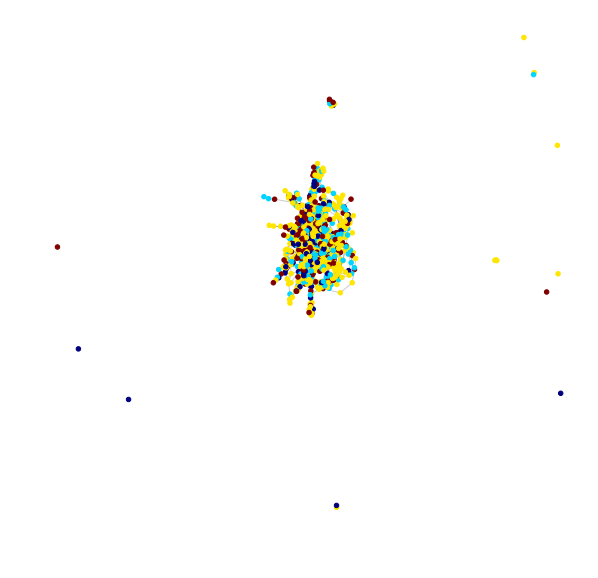

In [6]:
rows = list(range(1, len(m)+1))
df = pd.DataFrame(m, index=rows, columns=cols)
print(df)

pos = nx.spring_layout(gp.G)
plt.figure(figsize=(10, 10))
plt.axis('off')
colours = {0: 'red', 1: 'blue', 2: 'yellow', 3: 'green'}

colour = []
#for n in gp.G.nodes_iter():
#    colour += [colours[gp.assignments[n]]]

nx.draw_networkx_nodes(gp.G, pos, node_size=20, node_color=gp.assignments, cmap=plt.cm.jet, with_labels=False)
nx.draw_networkx_edges(gp.G, pos, alpha=0.2)
plt.show(gp.G)

# Assign Cut Off

In [7]:
m = gp.assign_cut_off()

Discarding prediction model


Assignments:
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

In [8]:
rows = list(range(1, len(m)+1))
df = pd.DataFrame(m, index=rows, columns=cols)
print(df)

   WASTE  CUT RATIO  EDGES CUT  TOTAL COMM VOLUME  Qds  CONDUCTANCE  MAXPERM  \
1      0        0.0          0                  0  0.0          0.0      0.0   

   NMI  FSCORE  FSCORE RELABEL IMPROVEMENT  
1  1.0       0                           0  


# Run Simulation

In [9]:
m = gp.batch_arrival()

Assigning in batches of 40
--------------------------------

Ran PaToH for 5 iterations with min_tcv = 0 and max_tcv = 0  - picked min_TCV assignements.
Ran PaToH for 5 iterations with min_tcv = 7 and max_tcv = 10  - picked min_TCV assignements.
Ran PaToH for 5 iterations with min_tcv = 22 and max_tcv = 27  - picked min_TCV assignements.
Ran PaToH for 5 iterations with min_tcv = 49 and max_tcv = 49  - picked min_TCV assignements.
Ran PaToH for 5 iterations with min_tcv = 80 and max_tcv = 100  - picked min_TCV assignements.
Ran PaToH for 5 iterations with min_tcv = 128 and max_tcv = 130  - picked min_TCV assignements.
Ran PaToH for 5 iterations with min_tcv = 171 and max_tcv = 178  - picked min_TCV assignements.

Assignments:
[-1 -1 -1 -1  2  3 -1 -1 -1 -1 -1 -1  0  3 -1 -1 -1  3  3 -1 -1 -1 -1 -1  2  2 -1 -1 -1  3 -1  0 -1  1 -1 -1 -1 -1  0 -1  2  1  3 -1 -1 -1 -1  1 -1 -1  1 -1 -1  0 -1  2  1 -1  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  3  2  1 -1 -1 -1 -1 -1  0 -1  1  3 -1 

      WASTE  CUT RATIO  EDGES CUT  TOTAL COMM VOLUME       Qds  CONDUCTANCE  \
1  0.000000   0.000000        0.0                0.0  0.241104     0.013824   
2  0.000000   0.071429        4.0                7.0  0.549992     0.009859   
3  0.000000   0.111111       13.0               22.0  0.560736     0.030331   
4  0.000000   0.162562       33.0               49.0  0.584783     0.039638   
5  0.100000   0.194357       62.0               80.0  0.484412     0.060358   
6  0.000000   0.242222      109.0              128.0  0.478400     0.065234   
7  0.003584   0.264559      159.0              171.0  0.487315     0.081504   

    MAXPERM       NMI    FSCORE  FSCORE RELABEL IMPROVEMENT  
1 -0.595833  0.184319  0.111389                    0.384744  
2 -0.166156  0.118765  0.119664                    0.333689  
3 -0.036492  0.122011  0.116082                    0.341185  
4  0.123173  0.121747  0.111230                    0.321873  
5  0.218216  0.121830  0.105307                    0.3007

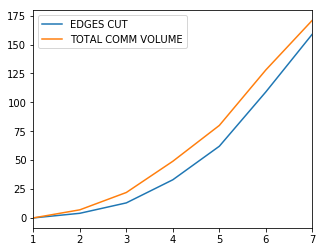

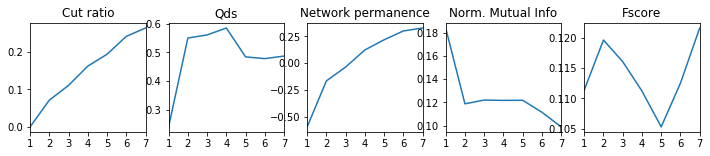

In [10]:
rows = list(range(1, len(m)+1))
df = pd.DataFrame(m, index=rows, columns=cols).astype(float)
print(df)

if len(df) > 1:
    '''
    df.plot(y=['EDGES CUT', 'TOTAL COMM VOLUME'], xticks=rows, figsize=(5,4))

    fig, axs = plt.subplots(1,6)
    df.plot(y=['CUT RATIO'], title='Cut ratio', xticks=rows, figsize=(12,2), legend=False, ax=axs[0])
    df.plot(y=['MODULARITY'], title='Modularity', xticks=rows, figsize=(12,2), legend=False, ax=axs[1])
    df.plot(y=['LONELINESS'], title='Loneliness', xticks=rows, figsize=(12,2), legend=False, ax=axs[2])
    df.plot(y=['NETWORK PERMANENCE'], title='Network permanence', xticks=rows, figsize=(12,2), legend=False, ax=axs[3])
    df.plot(y=['NORM. MUTUAL INFO'], title='Norm. Mutual Info', xticks=rows, figsize=(12,2), legend=False, ax=axs[4])
    df.plot(y=['FSCORE'], title='Fscore', xticks=rows, figsize=(12,2), legend=False, ax=axs[5])
    '''
    t = 1
    xticks = rows[::t]
    df.plot(y=['EDGES CUT', 'TOTAL COMM VOLUME'], xticks=xticks, figsize=(5,4))

    fig, axs = plt.subplots(1,5)
    df.plot(y=['CUT RATIO'], title='Cut ratio', xticks=xticks, figsize=(12,2), legend=False, ax=axs[0])
    df.plot(y=['Qds'], title='Qds', xticks=xticks, figsize=(12,2), legend=False, ax=axs[1])
    #df.plot(y=['LONELINESS'], title='Loneliness', xticks=xticks, figsize=(12,2), legend=False, ax=axs[2])
    df.plot(y=['MAXPERM'], title='Network permanence', xticks=xticks, figsize=(12,2), legend=False, ax=axs[2])
    df.plot(y=['NMI'], title='Norm. Mutual Info', xticks=rows, figsize=(12,2), legend=False, ax=axs[3])
    df.plot(y=['FSCORE'], title='Fscore', xticks=rows, figsize=(12,2), legend=False, ax=axs[4])



else:
    print("\n\nNot enough data points to plot charts. There is only one row.")

# Network Visual

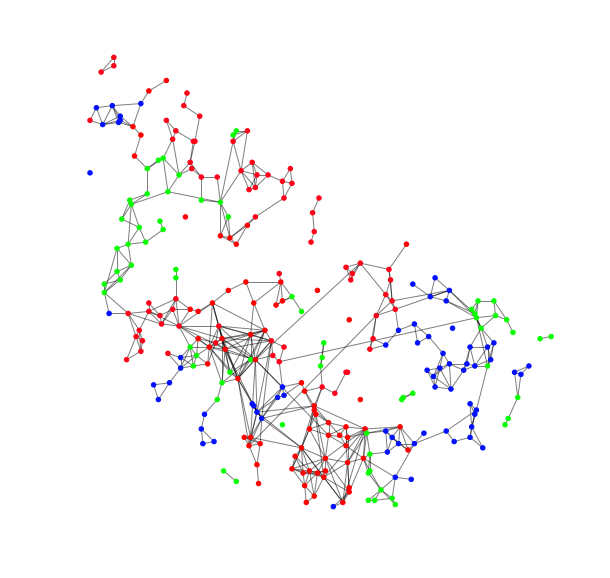

In [11]:
part = dict(zip(gp.G.nodes(), gp.assignments))
values = [part.get(node) for node in gp.G.nodes()]

pos_spring = nx.spring_layout(gp.G, k=0.5, iterations=20)

pos = {}
with open(gp.POPULATION_LOCATION_FILE, 'r') as csvfile: 
    reader = csv.reader(csvfile, delimiter=',')
    for node, row in enumerate(reader):
        pos[node] = np.array(row).astype(np.float)

# create colours
cmap = utils.get_cmap(gp.num_partitions)
colours = np.zeros((gp.G.number_of_nodes(), 4), dtype=np.float)
for i,n in enumerate(gp.G.nodes_iter()):
    if gp.assignments[n] == -1:
        col = [(1.0, 1.0, 1.0, 1.0)]
    else:
        col = [cmap(gp.assignments[n])]
    colours[i] = np.array(col, dtype=np.float)

plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx_nodes(gp.G, pos, node_size=20, node_color=colours, cmap=plt.cm.jet, with_labels=False)
nx.draw_networkx_edges(gp.G, pos, alpha=0.5)
plt.show(gp.G)

#nx.draw_networkx_nodes(gp.G, pos_spring, node_size=20, node_color=colour, cmap=plt.cm.jet, with_labels=False)
#nx.draw_networkx_edges(gp.G, pos_spring, alpha=0.5)
#plt.show(gp.G)

# Metrics

In [12]:
if run_metrics:
    gp.get_metrics()

Complete graph with 1000 nodes

Config
-------

file: 172039
num_partitions: 4
num_iterations: 1
prediction_model_cut_off: 0.0
restream_batches: 40
use_virtual_nodes: False
virtual_edge_weight: 1.0
edges_cut: 159

Metrics
-------

waste: 0.0010000000000000009
cut_ratio: 0.26455906821963393
total_communication_volume: 171
network_permanence: -0.620997
Q: 0.7743396313692862
NQ: -0.7955521736135005
Qds: 0.13046087353602737
intraEdges: 261.2826086956522
interEdges: 36.56521739130435
intraDensity: 0.16163416522720014
modularity degree: 231.9607765041976
conductance: 0.5063493260506428
expansion: 9.910209813070226
contraction: 19.99546096542664
fitness: 0.46989179116337393
QovL: 0.9296411421159722

Partition 0 with 70 nodes
-----------------------------


Metrics
file: 172039
partition: 0
population: 70
Q: 0.4428206071326235
NQ: -1.2136482126435053
Qds: 0.1059902452657825
intraEdges: 145.1818181818182
interEdges: 19.454545454545453
intraDensity: 0.03336839644693782
modularity degree: -62.302